# 全人類がわかるディープラーニング Day1演習

## 概要

本演習では深層学習の基礎である多層パーセプトロンによる学習を穴埋め形式で実装します。<br>
予め用意されたコード（訓練用・テスト用データの取得、ミニバッチ学習など）はそのまま使用し、指示された穴埋め部（順伝播と誤差逆伝播）を編集してください。<br>
問題は全20問、大きく2つの大問に分かれ、それぞれに10の小問がついています。問題文は<font color="Red">赤字</font>で表示されています。<br>
このファイルは必ず最後までコードをすべて実行し、「最後までコードが実行可能」・「学習結果の出力がある」・「学習が成功している」の３つを満たした状態で提出してください。

所要時間：3~5時間

## 大問１ 回帰モデル演習

### ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [2]:
import csv
import cv2
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline
# "%matplotlib inline" の代わりに以下のコマンドを使用できる場合、3次元で座標軸を操作可能なプロットを表示することができます。
# %matplotlib notebook


# 乱数シードを指定
np.random.seed(seed=0)

/Users/seijisuzuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict


### データの３次元散布図を作成する関数

データ可視化に使用します。演習の問題とは関係ありませんので読み飛ばしてください。

In [3]:
def plot_data(data, name='Data Plot'):
    # グラフ作成
    fig = plt.figure()
    ax = Axes3D(fig)

    # 軸ラベルの設定
    ax.set_xlabel("X0-axis")
    ax.set_ylabel("X1-axis")
    ax.set_zlabel("Y-axis")

    # 表示範囲の設定
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(0, 10)

    ax.plot(data[:, 0], data[:, 1], data[:, 2],
            "o", color="#ff2222", ms=2, mew=0.5)
    ax.set_title(name)
    plt.show()

### データの読み込み

本演習では、train_data.csvを訓練用データ、test_data.csvをテスト用データとして使用します。データはx0, x1, yの3列からなり、以下の式に従っています。

$$ y = \left\{ \begin{array}{ll} (x_0-1)^2 + (x_1-1)^2 & (x_0 \gt 0) \\ (x_0+1)^2 + (x_1+1)^2 & (x_0 \leq 0) \end{array} \right. $$

訓練データ10000個の(x0, x1, y)の組を多層パーセプトロンで学習し、テストデータ2000個の学習におけるコストの推移を観測します。
まずはデータのプロットを表示してみます。

※ここでエラーとなっている場合はライブラリのインポートが完了していないか、正常にデータを読み込めていません。同ディレクトリ内にダウンロードした`train_data.csv`と`test_data.csv`が存在していることを確認してください。

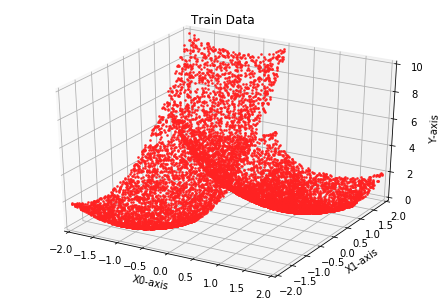

In [14]:
# データの読み込み
with open('/Users/seijisuzuki/Dropbox/@00_input/E_Day1/train_data.csv') as f:
    reader = csv.reader(f)
    train_data = np.array([[float(x) for x in row] for row in reader])
with open('/Users/seijisuzuki/Dropbox/@00_input/E_Day1/test_data.csv') as f:
    reader = csv.reader(f)
    test_data = np.array([[float(x) for x in row] for row in reader])

# 訓練データを可視化
plot_data(train_data, 'Train Data')

### データの数

In [15]:
N_train = train_data.shape[0]
print('訓練データの数: ', N_train)
N_test = test_data.shape[0]
print('テストデータの数: ', N_test)

訓練データの数:  10000
テストデータの数:  2000


### 活性化関数 relu

<font color="Red">問1-1 relu関数を完成させてください。</font>
- 以下の式で定義されるrelu関数を実装します。
$$ x = relu(v) = \left\{ \begin{array}{ll} v & (v \gt 0) \\ 0 & (v \leq 0) \end{array} \right. $$
- 引数`v`の各要素と0の大きい方を取り、`x`とします。
- ヒント: numpy.maximum()


In [16]:
def relu(v):
    '''
    活性化関数 relu
    v: (float) [N, M]
    x: (float) [N, M]
    '''
    x = np.maximum(0, v)
    return x

### コスト関数 平均二乗誤差

<font color="Red">問1-2 関数を完成させてください。</font>
- 以下の式で定義されるコスト関数を実装します。
$$ MSE = \frac{1}{n} \sum_{i}^{n} \sum_{j}^{k} (t_{ij}-y_{ij})^2 $$
$$ n:バッチサイズ, k:出力の次元 $$
- `t`と`y`の差の2乗の平均を取り、`mse`とします。
- ヒント: numpy.sum(), numpy.mean(), numpy.square()

In [17]:
def MSE(t, y):
    '''
    コスト関数 Mean Squared Error
    t: (float) [N, M]     
    y: (float) [N, M]
    mse: (float)
    '''
    mse = np.mean(np.sum(np.square(t-y)))
    
    #### 問1-2 ####
    return mse

### 多層パーセプトロンの定義

<font color="Red">問1-3 ~ 1-6 順伝播forward関数を完成させてください。</font>
- 以下の式で定義される順伝播を実装します。(Φは活性化関数)
$$
X_{i+1} = \phi(X_i \cdot W_i + B_i)
$$    
- 第1層`self.layer1`を定義します。入力層`self.layer0`と重み`self.w1`との内積を取り、バイアス`self.b1`を加算します。そして活性化関数`relu`に渡します。
- 第2層`self.layer2`を定義します。第1層`self.layer1`と重み`self.w2`との内積を取り、バイアス`self.b2`を加算します。そして活性化関数`relu`に渡します。
- 第3層`self.layer3`を定義します。第2層`self.layer2`と重み`self.w3`との内積を取り、バイアス`self.b3`を加算します。そして活性化関数`relu`に渡します。
- 出力層`self.out`を定義します。第3層`self.layer3`と重み`self.w4`との内積を取り、バイアス`self.b4`を加算します。
- 出力層では活性化関数Φは使用しないことに注意せよ
- ヒント: np.dot()<br>

<font color="Red"> 問1-7 ~ 1-10 逆伝播によって誤差と勾配を求めるbackward関数を完成させてください。</font>
- 出力層誤差`delta4`を定義します。二乗誤差の微分なので、以下の式に従います。
$$
\delta_{out} = \frac{d(T-Y)^2}{dY} = -2(T-Y)
$$
- 誤差逆伝播は以下の式に従います。
$$
\delta_i = \phi'(v_{i+1})*\delta_{i+1} \cdot W_{i+1}^t 
$$
$$
\phi'(v_i) = \left\{ \begin{array}{ll} v_i \frac{d}{dv_i} & (v_i \gt 0) \\ 0 \frac{d}{dv_i} & (v_i \leq 0) \end{array} \right. = 
\left\{ \begin{array}{ll} 1 & (v_i \gt 0) \\ 0 & (v_i \leq 0) \end{array} \right. = 
\left\{ \begin{array}{ll} 1 & (x_i \gt 0) \\ 0 & (x_i \leq 0) \end{array} \right.
\\
\phi(v_i) = x_i
$$
- 第3層誤差`delta3`を定義します。出力層誤差`delta4`と重み`self.w4`の転置との内積を取ります。
- 第2層誤差`delta2`を定義します。第3層誤差`delta3`と第3層`self.layer3`におけるreluの微分との積を取り、重み`self.w3`の転置との内積を取ります。
- 第1層誤差`delta1`を定義します。第2層誤差`delta2`と第2層`self.layer2`におけるreluの微分との積を取り、重み`self.w2`の転置との内積を取ります。
- ヒント: numpy.dot(), numpy.transpose()
- ヒント: reluの微分は該当する層の各要素が0より大きいものは1, 0以下のものは0としたベクトルに等しい
    

In [37]:
# 識別モデル
class MLP_regressor():
    '''
    多層パーセプトロン Multi Layered Perceptron
    構成: [入力層, 第1層, 第2層, 第3層, 出力層]
    ノード数: [2, 50, 50, 10, 1]
    '''

    def __init__(self):
        '''
        コンストラクタ
        パラメータ（重みw, バイアスb）の定義
        第1層重み self.w1: [2, 50] 平均0, 標準偏差0.1の乱数
        第2層重み self.w2: [50, 50] 平均0, 標準偏差0.1の乱数
        第3層重み self.w3: [50, 10] 平均0, 標準偏差0.1の乱数
        第4層重み self.w4: [10, 1] 平均0, 標準偏差0.1の乱数
        
        第1層バイアス self.b1: [50] 要素が全て0
        第2層バイアス self.b2: [50] 要素が全て0
        第3層バイアス self.b3: [10] 要素が全て0
        第4層バイアス self.b4: [1] 要素が全て0
        
        numpyの乱数については以下のページを参照
        https://docs.scipy.org/doc/numpy/reference/routines.random.html
        '''
        
        # 重みの定義
        self.w1 = np.random.randn(2, 50) * 0.1
        self.w2 = np.random.randn(50, 50) * 0.1
        self.w3 = np.random.randn(50, 10) * 0.1
        self.w4 = np.random.randn(10, 1) * 0.1

        # バイアスの定義
        self.b1 = np.zeros(50, dtype=float)
        self.b2 = np.zeros(50, dtype=float)
        self.b3 = np.zeros(10, dtype=float)
        self.b4 = np.zeros(1, dtype=float)

    def forward(self, x):
        '''
        順伝播
        入力 x: [N, 2]
        入力層 self.layer0: [N, 2]
        第1層 self.layer1: [N, 50]
        第2層 self.layer2: [N, 50]
        第3層 self.layer3: [N, 10]
        出力層 self.out: [N, 1]
        '''
        
        self.layer0 = x
        self.layer1 = relu(self.b1+ np.dot(x, self.w1))
        
        #### 問1-3 ####
        self.layer2 = relu(self.b2+ np.dot(self.layer1, self.w2))
        
        #### 問1-4 ####
        self.layer3 =  relu(self.b3+ np.dot(self.layer2, self.w3))

        #### 問1-5 ####
        self.out = relu(self.b4+ np.dot(self.layer3, self.w4))
        
        #### 問1-6 ####
        return self.out

    def backward(self, t, y):
        '''
        逆伝播
        真の値 t: [N, 1]
        予測値 y: [N, 1]
        
        出力層誤差 delta4: [N, 1]
        第3層誤差 delta3: [N, 10]
        第2層誤差 delta2: [N, 50]
        第1層誤差 delta1: [N, 50]
        
        第4層b勾配 dedb4: [1]
        第3層b勾配 dedb3: [10]
        第2層b勾配 dedb2: [50]
        第1層b勾配 dedb1: [50]
        
        第4層w勾配 dedw4: [10, 1]
        第3層w勾配 dedw3: [50, 10]
        第2層w勾配 dedw2: [50, 50]
        第1層w勾配 dedw1: [2, 50]
        '''
        
        # 出力層の誤差デルタは二乗誤差の微分
        delta4 = -2*(t-y)
        
        #### 問1-7 ####
        
        # 誤差逆伝播
        delta3 = np.dot(delta4, self.w4.transpose())
        
        #### 問1-8 ####
        
        ### relu(self.layer2)の値を得体が、50->10のためブロードキャストできない  ###
        delta2 = np.dot((relu(self.layer3) * delta3), self.w3.transpose())
        
        #### 問1-9 ####
        
        delta1 = np.dot((relu(self.layer1) * delta2), self.w2.transpose())
        
        #### 問1-10 ####

        # バイアスbのコスト関数eに対する勾配
        self.dedb4 = np.mean(delta4, axis=0)
        self.dedb3 = np.mean(delta3 * (self.layer3 > 0), axis=0)
        self.dedb2 = np.mean(delta2 * (self.layer2 > 0), axis=0)
        self.dedb1 = np.mean(delta1 * (self.layer1 > 0), axis=0)

        # 重みwのコスト関数eに対する勾配
        self.dedw4 = np.dot(self.layer3.T, delta4) / delta4.shape[0]
        self.dedw3 = np.dot(self.layer2.T, delta3 * (self.layer3 > 0)) / delta3.shape[0]
        self.dedw2 = np.dot(self.layer1.T, delta2 * (self.layer2 > 0)) / delta2.shape[0]
        self.dedw1 = np.dot(self.layer0.T, delta1 * (self.layer1 > 0)) / delta1.shape[0]

    def optimize_GradientDecent(self, lr):
        '''
        勾配降下法によるパラメータの更新
        '''
        self.b1 -= lr * self.dedb1
        self.b2 -= lr * self.dedb2
        self.b3 -= lr * self.dedb3
        self.b4 -= lr * self.dedb4

        self.w1 -= lr * self.dedw1
        self.w2 -= lr * self.dedw2
        self.w3 -= lr * self.dedw3
        self.w4 -= lr * self.dedw4

### 学習

以下ではこれまでで定義した多層パーセプトロンを使用し、データを学習します。
コストが正常に減少し、500epochで0.5以下にまで到達していれば学習は成功していると言えます。

In [38]:
# モデルの定義
model = MLP_regressor()

# 学習率
lr = 0.01
# 学習エポック数
n_epoch = 500

x_train = train_data[:, 0:2]
t_train = train_data[:, 2:3]
x_test = test_data[:, 0:2]
t_test = test_data[:, 2:3]

# n_epoch繰り返す
for n in range(n_epoch):
    # 訓練
    # Day1範囲外のため、ミニバッチは使用しない
    y = model.forward(x_train)
    train_loss = MSE(t_train, y)
    model.backward(t_train, y)
    model.optimize_GradientDecent(lr)

    # テスト
    y = model.forward(x_test)
    test_loss = MSE(t_test, y)

    print('EPOCH ', n + 1, ' | TRAIN LOSS ',
          train_loss, ' | TEST LOSS ', test_loss)
regression_loss = test_loss

EPOCH  1  | TRAIN LOSS  135592.79782949624  | TEST LOSS  27250.816926064006
EPOCH  2  | TRAIN LOSS  132986.96362861543  | TEST LOSS  26710.905551603384
EPOCH  3  | TRAIN LOSS  130327.5375328392  | TEST LOSS  26193.4527719964
EPOCH  4  | TRAIN LOSS  127779.67557901026  | TEST LOSS  25697.292638770872
EPOCH  5  | TRAIN LOSS  125337.24247682831  | TEST LOSS  25221.291365383062
EPOCH  6  | TRAIN LOSS  122994.67515633951  | TEST LOSS  24764.28676496581
EPOCH  7  | TRAIN LOSS  120746.07370969604  | TEST LOSS  24325.08089853828
EPOCH  8  | TRAIN LOSS  118585.7101752162  | TEST LOSS  23902.894872408106
EPOCH  9  | TRAIN LOSS  116509.68141595565  | TEST LOSS  23496.83319766922
EPOCH  10  | TRAIN LOSS  114513.77091899177  | TEST LOSS  23106.119784123977
EPOCH  11  | TRAIN LOSS  112593.959441741  | TEST LOSS  22730.309440762798
EPOCH  12  | TRAIN LOSS  110748.12347503785  | TEST LOSS  22368.9067198774
EPOCH  13  | TRAIN LOSS  108973.68449137377  | TEST LOSS  22021.38216182138
EPOCH  14  | TRAIN L

EPOCH  117  | TRAIN LOSS  65784.72862115187  | TEST LOSS  13419.138218691414
EPOCH  118  | TRAIN LOSS  65751.3879359382  | TEST LOSS  13411.737152046091
EPOCH  119  | TRAIN LOSS  65718.4091014555  | TEST LOSS  13404.410527202735
EPOCH  120  | TRAIN LOSS  65685.73016839559  | TEST LOSS  13397.152962259599
EPOCH  121  | TRAIN LOSS  65653.307288955  | TEST LOSS  13389.950775629328
EPOCH  122  | TRAIN LOSS  65621.10154857264  | TEST LOSS  13382.800941480567
EPOCH  123  | TRAIN LOSS  65589.08585184303  | TEST LOSS  13375.689683351009
EPOCH  124  | TRAIN LOSS  65557.18306893401  | TEST LOSS  13368.609413238277
EPOCH  125  | TRAIN LOSS  65525.358032801334  | TEST LOSS  13361.55794049089
EPOCH  126  | TRAIN LOSS  65493.580309516  | TEST LOSS  13354.526443465984
EPOCH  127  | TRAIN LOSS  65461.826190457614  | TEST LOSS  13347.512312651721
EPOCH  128  | TRAIN LOSS  65430.07847186065  | TEST LOSS  13340.506418900626
EPOCH  129  | TRAIN LOSS  65398.28390620577  | TEST LOSS  13333.500586995491
EPOC

EPOCH  228  | TRAIN LOSS  58221.16492855788  | TEST LOSS  11813.4202580187
EPOCH  229  | TRAIN LOSS  58056.192073979095  | TEST LOSS  11778.60697493124
EPOCH  230  | TRAIN LOSS  57887.64554974355  | TEST LOSS  11743.04981061066
EPOCH  231  | TRAIN LOSS  57715.51027767664  | TEST LOSS  11706.720203389108
EPOCH  232  | TRAIN LOSS  57539.64124152124  | TEST LOSS  11669.581097731705
EPOCH  233  | TRAIN LOSS  57359.881916875784  | TEST LOSS  11631.621338808705
EPOCH  234  | TRAIN LOSS  57176.17741039279  | TEST LOSS  11592.825040910906
EPOCH  235  | TRAIN LOSS  56988.42742602005  | TEST LOSS  11553.18002769929
EPOCH  236  | TRAIN LOSS  56796.62434073677  | TEST LOSS  11512.657531232877
EPOCH  237  | TRAIN LOSS  56600.61049096107  | TEST LOSS  11471.228331419346
EPOCH  238  | TRAIN LOSS  56400.243218281954  | TEST LOSS  11428.879939066028
EPOCH  239  | TRAIN LOSS  56195.442739446225  | TEST LOSS  11385.589772720523
EPOCH  240  | TRAIN LOSS  55986.08757233968  | TEST LOSS  11341.353056135033


EPOCH  337  | TRAIN LOSS  15296.170113232289  | TEST LOSS  2976.514136918482
EPOCH  338  | TRAIN LOSS  15067.226066408493  | TEST LOSS  2931.384422581414
EPOCH  339  | TRAIN LOSS  14847.29434963462  | TEST LOSS  2888.151640195673
EPOCH  340  | TRAIN LOSS  14636.784764670465  | TEST LOSS  2846.893928535461
EPOCH  341  | TRAIN LOSS  14436.191025346077  | TEST LOSS  2807.5827916292205
EPOCH  342  | TRAIN LOSS  14245.119146056411  | TEST LOSS  2770.0078504433113
EPOCH  343  | TRAIN LOSS  14062.435502835273  | TEST LOSS  2734.1112692855604
EPOCH  344  | TRAIN LOSS  13887.969543815096  | TEST LOSS  2699.881260311948
EPOCH  345  | TRAIN LOSS  13721.449193254624  | TEST LOSS  2667.2850498288853
EPOCH  346  | TRAIN LOSS  13562.846966804143  | TEST LOSS  2636.1897716158346
EPOCH  347  | TRAIN LOSS  13411.516223897082  | TEST LOSS  2606.6726316871054
EPOCH  348  | TRAIN LOSS  13267.965246292119  | TEST LOSS  2578.6279992987
EPOCH  349  | TRAIN LOSS  13131.625926397079  | TEST LOSS  2551.736107747

EPOCH  445  | TRAIN LOSS  9033.912828380957  | TEST LOSS  1760.8331274682205
EPOCH  446  | TRAIN LOSS  9016.08715466154  | TEST LOSS  1757.6383760827998
EPOCH  447  | TRAIN LOSS  8998.479259699428  | TEST LOSS  1754.4038896713541
EPOCH  448  | TRAIN LOSS  8980.727579357346  | TEST LOSS  1751.2222662454274
EPOCH  449  | TRAIN LOSS  8963.222887138822  | TEST LOSS  1748.0215424128992
EPOCH  450  | TRAIN LOSS  8945.7321846361  | TEST LOSS  1744.8685162673032
EPOCH  451  | TRAIN LOSS  8928.429057364972  | TEST LOSS  1741.771221805186
EPOCH  452  | TRAIN LOSS  8911.392083882467  | TEST LOSS  1738.6579063410577
EPOCH  453  | TRAIN LOSS  8894.48917710856  | TEST LOSS  1735.551380928904
EPOCH  454  | TRAIN LOSS  8877.694771278435  | TEST LOSS  1732.4901804253363
EPOCH  455  | TRAIN LOSS  8861.083264764779  | TEST LOSS  1729.4530245927924
EPOCH  456  | TRAIN LOSS  8844.574271271647  | TEST LOSS  1726.4458146616148
EPOCH  457  | TRAIN LOSS  8828.309492737953  | TEST LOSS  1723.4184866889916
EPOCH

### 予測データの散布図

予測値の散布図と訓練データの散布図を比較してみましょう。

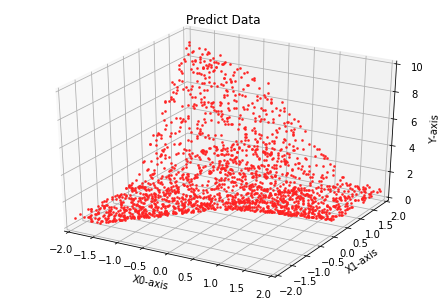

In [27]:
y = model.forward(x_test)
predict_data = np.concatenate([x_test, y], axis=1)
plot_data(predict_data, 'Predict Data')

## 大問２ 分類モデル演習

大問１では層ごとに変数を定義し全計算を実装しましたが、大問２ではクラスと計算グラフを利用し、より汎用的なモデルを設計します。

### データの読み込み

本演習では、mnist(手書き数字データセット)を使用し、全結合ネットワークで手書き数字の画像の10分類を行います。

In [47]:
# データの読み込み
with open('/Users/seijisuzuki/Dropbox/@00_input/E_Day1/mnist_784.dms','rb') as f:
    mnist = pickle.load(f)
        
    
# 画像とラベルを取得
X, T = mnist.data, mnist.target
# 訓練データとテストデータに分割
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2)

In [48]:
# ラベルデータをint型にし、one-hot-vectorに変換します
T_train = np.eye(10)[T_train.astype("int")]
T_test = np.eye(10)[T_test.astype("int")]

### one-hot-vectorとは？
たとえば$a$が，0~9の整数のみを含むベクトルだとわかっている時に、各要素を数字に該当する列の要素のみが1、その他が0となるようなベクトルにする。
$$
\begin{equation*}
a=
\begin{pmatrix}
1\\
8\\
4\\
2\\
0
\end{pmatrix}\to
a\_onehot = 
\begin{pmatrix}
0, 1, 0, 0, 0, 0, 0, 0, 0, 0\\
0, 0, 0, 0, 0, 0, 0, 0, 1, 0\\
0, 0, 0, 0, 1, 0, 0, 0, 0, 0\\
0, 0, 1, 0, 0, 0, 0, 0, 0, 0\\
1, 0, 0, 0, 0, 0, 0, 0, 0, 0
\end{pmatrix}
\end{equation*}
$$
学習する正解ラベルデータは，one-hot-vectorで表されることが多い．

### データの構造
データ数、画像データXの形、ラベルTの形などを調べます。

In [49]:
N_train = len(X_train)
N_test = len(X_test)
X_shape = X_train[0].shape
T_shape = T_train[0].shape

print('訓練データ数\t', N_train)
print('テストデータ数\t', N_test)
print('説明変数の形\t', X_shape)
print('ラベルの形\t', T_shape)

訓練データ数	 56000
テストデータ数	 14000
説明変数の形	 (784,)
ラベルの形	 (10,)


### データのサンプリング
画像・ラベルデータをランダムにいくつか取り出して可視化します。
画像は784要素の1次元ベクトルとしてXに格納されていますが、画像として表示するときは28x28の二次元にreshapeします。

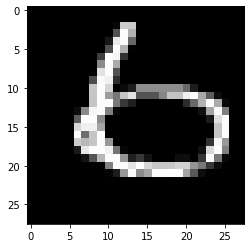

Label:  6


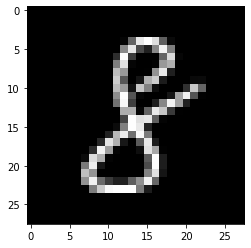

Label:  8


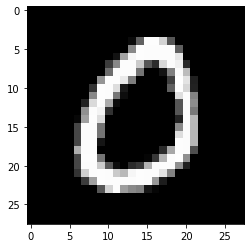

Label:  0


In [52]:
# テストデータをランダムサンプリング
perm = np.random.permutation(len(X_test))
# サンプル画像を表示する
plt.gray()
for i in perm[:3]:
    plt.imshow(X_test[perm[i]].reshape(28, 28))
    plt.show()
    print('Label: ', np.argmax(T_test[perm[i]]))

### softmax関数
<font color="Red">問2-1, 2-2 softmax関数を完成させてください。</font>

```
引数:
    x: [N, M] (np.float)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float)
```

バッチ計算が可能なsoftmax関数を実装します。<br>
exp関数がオーバーフローすることを防ぐために、各データについて入力信号の最大値を引いて、0以下にします。<br>
    numpyでは```[N, M] - [N]```の計算はブロードキャストができませんので、```x```を転置し```[M, N] - [N]```の形で計算を行ったあと、さらに転置をして元の形に戻します。
$$
softmax(x_{ij}) = \frac{e^{x_{ij}'}}{\sum_{k}^{M}{e^{x_{ik}'}}} \\ 
    x_{ij}' = x_{ij} - max_{j}x_{ij}
$$

In [63]:
def softmax(x):
    x = x.T
    x = x- np.max(x, axis=0)
    _x = np.exp(x)/ np.sum(np.exp(x), axis=0)
    
#### 問2-1 ####
#### 問2-2 ####
    return _x.T

### 交差エントロピー誤差
<font color="Red">問2-3 交差エントロピー誤差を完成させてください。</font>
```
引数:
    t: [N, M] (np.float)
    y: [N, M] (np.float)
返値:
    error: (np.float)
```
バッチ計算が可能な交差エントロピー誤差関数を実装します。<br>
```y == 0```のときlog関数が破綻しないよう、$ y $ に小さな値 $ \delta = 10^{-8}$ を加算します。
error は 以下の式に従います。
$$ error = -\frac {1}{N} \sum_{i}^{N} \sum_{j}^{M} {t_{ij} * log{(y_{ij} + \delta)}} $$

In [56]:
def cross_entropy_error(t, y):
    delta = 1e-8
    error = -1 * np.mean(np.sum(t*np.log(y+delta)))
    
    #### 問2-3 ####
    return error

### ソフトマックスクロスエントロピー誤差
<font color="Red">問2-4 ソフトマックスクロスエントロピー誤差を完成させてください。</font>

ソフトマックスクロスエントロピー誤差の順伝播と逆伝播のクラスを実装します。<br>
順伝播```__call__(self, t, y)```ではyのソフトマックスを取り、tとのクロスエントロピー誤差を返します。その際にyとtをインスタンス変数self.yとself.tに記憶します。関数名を```__call__```としているのは、**関数オブジェクト**を作ることで"インスタンス名()"で順伝播を呼び出せるようにするためです。<br>
逆伝播```backward(self)```では、順伝播で記憶されたself.yとself.tを使用して誤差に対する(softmaxを通す前の)yの勾配dyを計算します。<br>
yの勾配は以下の式に従います。<br>
※コードの```dy```と式の$ dy $は意味が異なり、```dy``` = $ \frac {dL(t, y)}{dy} $であることに注意してください。
$$ \frac {dL(t, y)}{dy} = softmax(y) - t $$
また、以降の計算ではバッチの平均を取るため、dyはバッチサイズで割ってから返します。

In [66]:
class SoftmaxCrossEntropyLoss():
    def __init__(self):
        self.y = None
        self.t = None
        self.loss = None
        
    def __call__(self, t, y):
        self.y = softmax(y)
        self.t = t.copy()
        self.loss = cross_entropy_error(self.t, self.y)
        return self.loss
    
    def backward(self):
        batch_size = self.t.shape[0]
        dy = self.y - self.t
        
#        dy = softmax(self.y) - self.t

        #### 問2-4 ####
        dy /= batch_size
        return dy

### 全結合層
<font color="Red">問2-5 ~ 2-8 全結合層クラスを完成させてください。</font>

全結合層の順伝播と逆伝播のクラスを実装します。
```
インスタンス変数:
    self.w: [N, M] (np.float)
            層の重み。正規分布で初期化。
    self.b: [M] (np.float)
            層のバイアス。ゼロで初期化。
    self.x: [L, N] (np.float)
            層の入力信号を記録。Lはバッチサイズ
    self.dw: [N, M] (np.float)
            層の重みの勾配
    self.db: [M] (np.float)
            層のバイアスの勾配
            
__call__(self, x):
    引数:
        x: [L, N] (np.float)
            入力信号
    返値:
        out: [L, M] (np.float)
            出力信号

backward(self, dout):
    引数:
        dout: [L, M] (np.float)
            出力信号の勾配
    返値:
        dx: [L, N] (np.float)
            入力信号の勾配
        
```
順伝播```__call__(self, x)```は入力信号xを層の重み```self.w```とバイアス```self.b```でアフィン変換し出力とします。
計算は以下の式に従います。
$$
Affine(x) = x \cdot w + b
$$
逆伝播```backward(self, dout)```は出力側の勾配[L, M]を入力側に逆伝播ます。入力の勾配```dx```、重みの勾配```dw```、バイアスの勾配```db```それぞれを計算し、```dx```を返します。
計算は以下の式に従います。
$$
grad(x_{ij}) = \sum_{k} grad(out_{ik}) \frac{dout_{ik}}{dx_{ij}}
$$
$$
grad(x_{ij}) = \sum_{k} grad(out_{ik})w_{jk}
$$
$$
grad(x) = grad(out) \cdot w^T \\ \space
$$
$$
grad(w_{jk}) = \sum_{i} grad(out_{ik}) \frac{dout_{ik}}{dw_{jk}}
$$
$$
grad(w_{jk}) = \sum_{i} grad(out_{ik})x_{ij}
$$
$$
grad(w) = x^T \cdot grad(out) \\ \space
$$
$$
grad(b_{k}) = \sum_{i} grad(out_{ik}) \frac{dout_{ik}}{db_{k}}
$$
$$
grad(b) = \sum_{i} grad(out_{i})
$$
    
実装コードでは$ grad(x) $ = ```dx```, $ grad(w) $ = ```dw```, $ grad(b) $ = ```db```と命名されています。 

In [59]:
class FullyConnectedLayer():
    def __init__(self, input_shape, output_shape):
        self.w = np.random.randn(input_shape, output_shape) * 0.01
        self.b = np.zeros(output_shape, dtype=np.float)
        self.x = None
        self.dw = None
        self.db = None
        
    def __call__(self, x):
        self.x = x
        out = np.dot(self.x, self.w) + self.b
        
        #### 問2-5 ####
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.w.T)
        
        #### 問2-6 ####
        batch_size = dx.shape[0]
        self.dw = np.dot(self.x.T, dout)
        
        #### 問2-7 ####
        self.db = np.sum(dout, axis=0)
        
        #### 問2-8 ####
        return dx

### ReLU
<font color="Red">問2-9 ~ 2-10 ReLUクラスを完成させてください。</font>
```
インスタンス変数:
    self.mask: [L, N] np.bool
               マスクされるxのフラッグ
               
__call__(self, x):
    引数:
        x: [L, N] np.float
    返値:
        out: [L, N] np.float

backward(self, dout):
    引数:
        dout: [L, N] np.float
    返値:
        dx: [L, N] np.float
    
```
ReLUの順伝播と逆伝播をクラスで実装します。
順伝播```__call__(self, x)```は入力信号xに対して、```x <= 0```部分が1、それ以外は0となるようなマトリックスself.maskを定義します。numpy配列の**ブールインデックス参照**を利用し、xのマスク部を0に変換し返します。
逆伝播```backward(self, dout)```は出力信号の勾配doutの保存されたマスク部を0に変換し、dxとして入力信号の勾配を返します。

In [60]:
class ReLU():
    def __init__(self):
        self.mask = None

    def __call__(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        #### 問2-9 #### = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        
        #### 問2-10 #### = 0
        dx = dout

        return dx

問題は以上になります。以下のモデルの構築と学習で実装が正しいことを確認しましょう。

### モデルの構築

これまで各種の層をクラスで定義できましたので、ここではそれらを組み合わせることでモデルを簡単に設計することができます。問題にはなっていませんが、コードからモデルの構築の全体像を把握しましょう。

In [61]:
# 分類モデル
class MLP_classifier():

    def __init__(self):
        '''
        構造
        x -> fc(783, 256) -> relu -> fc(256, 256) -> relu -> fc(256, 10) -> out
        '''
        
        # 層の定義
        self.fc1 = FullyConnectedLayer(784, 256)
        self.relu1 = ReLU()
        self.fc2 = FullyConnectedLayer(256, 256)
        self.relu2 = ReLU()
        self.fc3 = FullyConnectedLayer(256, 10)
        self.out = None
        
        # 損失関数の定義
        self.criterion = SoftmaxCrossEntropyLoss()

    def forward(self, x):
        '''
        順伝播
        '''
        
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        self.out = self.fc3(x)
        
        # backwardとの一貫性のためsoftmaxはこの順伝播関数内では行わない
        # 予測するときはさらにsoftmaxを通す必要がある
        return self.out

    def backward(self, t):
        '''
        逆伝播
        '''
        
        # 誤差を計算
        loss = self.criterion(t, self.out)
        # 勾配を逆伝播
        d = self.criterion.backward()
        d = self.fc3.backward(d)
        d = self.relu2.backward(d)
        d = self.fc2.backward(d)
        d = self.relu1.backward(d)
        d = self.fc1.backward(d)
        
        return loss

    def optimize_GradientDecent(self, lr):
        '''
        勾配降下法による全層のパラメータの更新
        '''
        for fc in [self.fc1, self.fc2, self.fc3]:
            fc.w -= lr * fc.dw
            fc.b -= lr * fc.db
        

### 学習

20epochで分類精度が80%以上になっていれば学習は成功していると言えます。

In [67]:
# モデルの宣言
model = MLP_classifier()

# 学習率
lr = 0.005
# 学習エポック数
n_epoch = 20

# n_epoch繰り返す
for n in range(n_epoch):
    # 訓練
    # Day1範囲外のため、ミニバッチは使用しない
    y = model.forward(X_train)
    loss = model.backward(T_train)
    model.optimize_GradientDecent(lr)
    
    # テスト
    y = model.forward(X_test)
    test_loss = model.backward(T_test)
    pred = softmax(y)
    accuracy = np.mean(np.equal(np.argmax(y, axis=1), np.argmax(T_test, axis=1)))
    print(f'EPOCH {n + 1} | TRAIN LOSS {loss:.5f} | TEST LOSS {test_loss:.5f} | ACCURACY {accuracy:.2%}')
classification_accuracy = accuracy

EPOCH 1 | TRAIN LOSS 131363.67451 | TEST LOSS 31291.42436 | ACCURACY 15.43%
EPOCH 2 | TRAIN LOSS 125140.61708 | TEST LOSS 29848.56136 | ACCURACY 26.35%
EPOCH 3 | TRAIN LOSS 119397.11383 | TEST LOSS 28455.00249 | ACCURACY 33.33%
EPOCH 4 | TRAIN LOSS 113846.61900 | TEST LOSS 27083.30166 | ACCURACY 36.48%
EPOCH 5 | TRAIN LOSS 108375.27041 | TEST LOSS 25741.47582 | ACCURACY 38.43%
EPOCH 6 | TRAIN LOSS 103003.63289 | TEST LOSS 24446.77925 | ACCURACY 40.24%
EPOCH 7 | TRAIN LOSS 97789.85798 | TEST LOSS 23210.64592 | ACCURACY 42.64%
EPOCH 8 | TRAIN LOSS 92775.93749 | TEST LOSS 22067.26470 | ACCURACY 45.21%
EPOCH 9 | TRAIN LOSS 88098.09618 | TEST LOSS 21138.59591 | ACCURACY 47.54%
EPOCH 10 | TRAIN LOSS 84230.67803 | TEST LOSS 20664.57709 | ACCURACY 49.66%
EPOCH 11 | TRAIN LOSS 82108.62188 | TEST LOSS 21029.47809 | ACCURACY 51.36%
EPOCH 12 | TRAIN LOSS 83240.65158 | TEST LOSS 22732.11417 | ACCURACY 53.00%
EPOCH 13 | TRAIN LOSS 89597.17631 | TEST LOSS 26501.67045 | ACCURACY 53.89%
EPOCH 14 | TRAI

### 提出可否

In [68]:
print("大問1 回帰ロス: ", regression_loss)
print("大問2 分類精度: ", classification_accuracy)
pass0 = regression_loss < 0.5
pass1 = classification_accuracy > 0.8
if pass0 and pass1:
    print("回帰モデルと分類モデルどちらも学習が成功しているので、提出可能です。")
else:
    if not pass0:
        print("回帰モデル（大問１）の学習が成功していません。")
    if not pass1:
        print("分類モデル（大問２）の学習が成功していません。")
    print("回答を訂正してください。")

大問1 回帰ロス:  1610.535367795792
大問2 分類精度:  0.31921428571428573
回帰モデル（大問１）の学習が成功していません。
分類モデル（大問２）の学習が成功していません。
回答を訂正してください。


### 補足

今演習では簡単のため、ミニバッチ学習・重み減衰などの正則化・より高度な最適化・データのオーグメンテーション(拡張)など、Day2, Day3で学習する重要な手法を使用していません。これらを使用すれば、全結合層でもmnist手書き数字の分類精度を大きく上げることが可能です。例えばミニバッチを簡単に導入するだけで、20epochで97%以上の精度に達します。

### 発展

大問１，大問２それぞれについて学習率・エポック数を変えてみて学習における挙動を観察してみましょう。また、多層パーセプトロンの総数やノード数を変更し、より良い精度を出せる条件を探してみましょう。